In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.stats import beta
import matplotlib.pyplot as plt
from scipy.stats import betabinom, binom
np.random.seed(512)

In [3]:
def build_assignment_matrix(attribute_dict, n_cell_types):
    data = list(attribute_dict.items())
    data = np.array(data)  # Assignment matrix

    B = np.zeros((data.shape[0], n_cell_types))  # Empty matrix

    for i in range(0, data.shape[0]):
        t = int(data[i, 1])
        B[i, t] = 1

    return B

def calculate_FOV_size(sampling_frac, min_x, max_x, min_y, max_y):
    area = (max_x - min_x) * (max_y - min_y)
    sampling_area = sampling_frac * area
    FOV_dim = np.round(np.sqrt(sampling_area))
    return FOV_dim

def random_FOV(FOV_dim, df, min_x, max_x, min_y, max_y):
    x_start = np.random.randint(min_x, max_x - FOV_dim)
    y_start = np.random.randint(min_y, max_y - FOV_dim)
    
    x_filtered = df[(df['segment_px_x'] > x_start) & (df['segment_px_x'] < x_start + FOV_dim)]
    random_FOV = x_filtered[(x_filtered['segment_px_y'] > y_start) & (x_filtered['segment_px_y'] < y_start + FOV_dim)]
    
    return random_FOV

def calculate_p_in_fov(fov, n_cell_types):
    types_in_fov = fov['cell_type_id'].astype(int).tolist()
    #print(types_in_fov)
    attribute_dict = dict(zip(fov.index, types_in_fov))
    B = build_assignment_matrix(attribute_dict, n_cell_types)
    return np.divide(np.sum(B, axis=0), B.shape[0])

def estimate_beta_from_FOV(df, fov_dim, type_of_interest, n_fov, x_min, x_max, y_min, y_max, n_cell_types):
    p_list = []
    i = 0
    ns = []
    while i < n_fov:
        fov = random_FOV(fov_dim, df, x_min, x_max, y_min, y_max)
        if len(fov) > 5:
            # because we don't define the boundary of the TISSUE just the boundary of the image
            # you could draw an fov out of tissue bounds but in the enclosing rectangle
            p_list.append(calculate_p_in_fov(fov, n_cell_types))
            ns.append(len(fov))
            i += 1
        else:
            continue
    print(ns)
    sample_proportions = np.vstack(p_list)
    props_of_interest = sample_proportions[:, type_of_interest]
    
    sample_mean = np.mean(props_of_interest)
    sample_var = np.var(props_of_interest)
    
    #print()
    alpha_hat = sample_mean * (((sample_mean*(1-sample_mean))/sample_var) - 1)
    beta_hat = (1 - sample_mean) * (((sample_mean*(1-sample_mean))/sample_var) - 1)

    return alpha_hat, beta_hat, props_of_interest, ns

def estimate_beta_from_FOV_ds(df, fov_dim, type_of_interest, n_fov, x_min, x_max, y_min, y_max, 
                           n_cell_types, target_size):
    p_list = []
    i = 0
    ns = []
    while i < n_fov:
        fov = random_FOV(fov_dim, df, x_min, x_max, y_min, y_max)
        if len(fov) == target_size:
            # because we don't define the boundary of the TISSUE just the boundary of the image
            # you could draw an fov out of tissue bounds but in the enclosing rectangle
            p_list.append(calculate_p_in_fov(fov, n_cell_types))
            ns.append(len(fov))
            i += 1
        elif len(fov) > target_size:
            #n_to_remove = len(fov) - target_size
            fov = fov.sample(n=target_size, replace=False)
            p_list.append(calculate_p_in_fov(fov, n_cell_types))
            ns.append(len(fov))
            i += 1
        else:
            continue
    #print(ns)
    sample_proportions = np.vstack(p_list)
    props_of_interest = sample_proportions[:, type_of_interest]
    
    sample_mean = np.mean(props_of_interest)
    sample_var = np.var(props_of_interest)
    
    #print()
    alpha_hat = sample_mean * (((sample_mean*(1-sample_mean))/sample_var) - 1)
    beta_hat = (1 - sample_mean) * (((sample_mean*(1-sample_mean))/sample_var) - 1)

    return alpha_hat, beta_hat, props_of_interest

def p_fov_with_rarest(a, b, m, N):
    return 1 - np.power((BF(a, b + m)/BF(a, b)), N)

def fov_cell_counts(df, fov_dim, toi, n_fov, x_min, x_max, y_min, y_max, n_cell_types, ret_n = False):
    
    p_list = []
    i = 0
    ns = []
    while i < n_fov:
        fov = random_FOV(fov_dim, df, x_min, x_max, y_min, y_max)
        if len(fov) > 10:
            types_in_fov = fov['cell_type_id'].astype(int).tolist()
            #print(types_in_fov)
            attribute_dict = dict(zip(fov.index, types_in_fov))
            B = build_assignment_matrix(attribute_dict, n_cell_types)
            p_list.append(np.sum(B, axis=0))
            ns.append(len(fov))
            i += 1
        else:
            continue
        
    sample_counts = np.vstack(p_list)
    
    if ret_n == True:
        return sample_counts[:, toi].astype(int), np.sum(sample_counts, axis=1).astype(int)
    else:
        return sample_counts[:, toi].astype(int)
    
def convert_params(m, k):
    """ 
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    Parameters
    ----------
    m : float 
       Mean
    k : float
       Overdispersion parameter. 
    """
    k = 1/k
    var = m + k * m ** 2
    p = (var - m) / var
    r = m ** 2 / (var - m)
    return r, 1-p

def get_type_from_B(cell_id, B):
    idx,  = np.where(B[cell_id])
    cell_type = idx[0]
    return cell_type

In [4]:
A = np.load('./results/sample_adjmat_20200601.npy')
C = np.load('./results/sample_positions_20200601.npy')

In [7]:


#Load data and do calcs
B = np.load('./results/rarecell_optimized_B.npy')
for i in range(0, B.shape[0]):
    l, = np.where(B[i,:])
    if len(l) > 1:
        #Randomly assign from the equally likely possibilities
        to_zero = np.random.choice(l, len(l)-1, replace=False)
        for j in to_zero:
            B[i, j] = 0
            
type_col = [get_type_from_B(i, B) for i in range(0, A.shape[0])]
df = pd.DataFrame(np.hstack((C, np.array(type_col).reshape(len(type_col),1).astype(int))),columns=['segment_px_x', 'segment_px_y', 'cell_type_id'])

toi = 0
n_fov = 10
n_cell_types = 4
x_min = min(df['segment_px_x'])
x_max = max(df['segment_px_x'])
y_min = min(df['segment_px_y'])
y_max = max(df['segment_px_y'])

fov_size_05r = calculate_FOV_size(0.01, x_min, x_max, y_min, y_max)
fov_size_1r = calculate_FOV_size(0.01, x_min, x_max, y_min, y_max)
fov_size_5r = calculate_FOV_size(0.05, x_min, x_max, y_min, y_max)
fov_size_10r = calculate_FOV_size(0.1, x_min, x_max, y_min, y_max)


n_toi_observed, ns = fov_cell_counts(df, fov_size_5r, toi, n_fov, x_min, x_max, y_min, y_max, n_cell_types, ret_n=True)
props_of_interest = np.divide(n_toi_observed, ns)
sample_mean = np.mean(props_of_interest)
sample_var = np.var(props_of_interest)
alpha_hat_rare = sample_mean * (((sample_mean*(1-sample_mean))/sample_var) - 1)
beta_hat_rare = (1 - sample_mean) * (((sample_mean*(1-sample_mean))/sample_var) - 1)

B = np.load('./results/negcontrol_optimized_B.npy')
for i in range(0, B.shape[0]):
    l, = np.where(B[i,:])
    if len(l) > 1:
        #Randomly assign from the equally likely possibilities
        to_zero = np.random.choice(l, len(l)-1, replace=False)
        for j in to_zero:
            B[i, j] = 0
type_col = [get_type_from_B(i, B) for i in range(0, A.shape[0])]
df = pd.DataFrame(np.hstack((C, np.array(type_col).reshape(len(type_col),1).astype(int))),columns=['segment_px_x', 'segment_px_y', 'cell_type_id'])
n_toi_observed, ns = fov_cell_counts(df, fov_size_5r, toi, n_fov, x_min, x_max, y_min, y_max, n_cell_types, ret_n=True)
props_of_interest = np.divide(n_toi_observed, ns)
sample_mean = np.mean(props_of_interest)
sample_var = np.var(props_of_interest)
alpha_hat_neg = sample_mean * (((sample_mean*(1-sample_mean))/sample_var) - 1)
beta_hat_neg = (1 - sample_mean) * (((sample_mean*(1-sample_mean))/sample_var) - 1)

B = np.load('./results/self_preference_B_regionheuristic_06082020.npy')
for i in range(0, B.shape[0]):
    l, = np.where(B[i,:])
    if len(l) > 1:
        #Randomly assign from the equally likely possibilities
        to_zero = np.random.choice(l, len(l)-1, replace=False)
        for j in to_zero:
            B[i, j] = 0

n_toi_observed, ns = fov_cell_counts(df, fov_size_5r, toi, n_fov, x_min, x_max, y_min, y_max, n_cell_types, ret_n=True)
props_of_interest = np.divide(n_toi_observed, ns)
sample_mean = np.mean(props_of_interest)
sample_var = np.var(props_of_interest)
alpha_hat_sp = sample_mean * (((sample_mean*(1-sample_mean))/sample_var) - 1)
beta_hat_sp = (1 - sample_mean) * (((sample_mean*(1-sample_mean))/sample_var) - 1)



<Figure size 432x288 with 0 Axes>

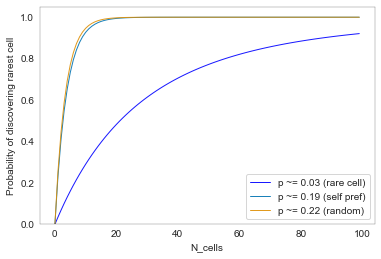

In [16]:
import matplotlib
from matplotlib import cm, colors
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial'})

plt.clf()
sns.set_style("white")
sns.set_palette("colorblind")
fig, ax = plt.subplots(1, 1)
x = np.arange(0, 100)

ax.plot(x, betabinom.sf(0, x, alpha_hat_rare, beta_hat_rare), lw = 1, label=r"p ~= 0.03 (rare cell)", alpha = 0.9, c = 'b')
ax.plot(x, betabinom.sf(0, x, alpha_hat_sp, beta_hat_sp), lw = 1, label=r"p ~= 0.19 (self pref)", alpha = 0.9)
ax.plot(x, betabinom.sf(0, x, alpha_hat_neg, beta_hat_neg), lw = 1, label=r"p ~= 0.22 (random)", alpha = 0.9)

ax.set_xlabel(r'N_cells')
ax.set_ylabel(r'Probability of discovering rarest cell')
ax.set_ylim(0,1.05)
plt.legend()
#plt.savefig('./spleen_data/figures/FigureS3A.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

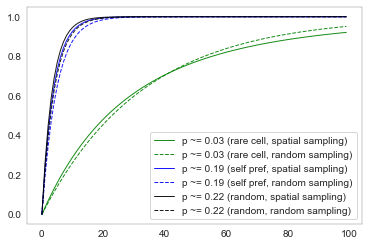

In [24]:
matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial'})

plt.clf()
sns.set_style("white")
sns.set_palette("colorblind")
fig, ax = plt.subplots(1, 1)
x = np.arange(0, 100)

ax.plot(x, betabinom.sf(0, x, alpha_hat_rare, beta_hat_rare), lw = 1, label=r"p ~= 0.03 (rare cell, spatial sampling)", alpha = 0.9, c = 'g')
ax.plot(x, binom.sf(0, x, 0.03), lw = 1, linestyle='dashed', c='g', label=r"p ~= 0.03 (rare cell, random sampling)", alpha = 0.9)
ax.plot(x, betabinom.sf(0, x, alpha_hat_sp, beta_hat_sp), lw = 1, label=r"p ~= 0.19 (self pref, spatial sampling)", alpha = 0.9, c='b')
ax.plot(x, binom.sf(0, x, 0.19), lw = 1, label=r"p ~= 0.19 (self pref, random sampling)", alpha = 0.9, c='b', linestyle='dashed')
ax.plot(x, betabinom.sf(0, x, alpha_hat_neg, beta_hat_neg), lw = 1, label=r"p ~= 0.22 (random, spatial sampling)", alpha = 0.9, c='k')
ax.plot(x, binom.sf(0, x, 0.22), lw = 1, label=r"p ~= 0.22 (random, random sampling)", alpha = 0.9, c='k', linestyle='dashed')
plt.legend()
plt.show()


## S3B

In [67]:
from scipy.optimize import fsolve
from scipy.stats import nbinom

In [117]:
def p_discovery_in_n_fov(p0, n):
        return 1 - np.power(p0, n)
    
def do_model_trials(df, fov_size, toi, n_cell_types, n_fov, n_trials, guess):
    
    x_min = min(df['segment_px_x'])
    x_max = max(df['segment_px_x'])
    y_min = min(df['segment_px_y'])
    y_max = max(df['segment_px_y'])

    trial_counter = 0
    
    def f2(k, p0, m):
            return np.power((m/k + 1), -k) - p0
    ns = np.arange(0,10)
    while trial_counter < n_trials:
        n_toi_observed = fov_cell_counts(df, fov_size, toi, n_fov, x_min, x_max, y_min, y_max, n_cell_types)
        values, counts = np.unique(n_toi_observed, return_counts=True)
        v = np.arange(0, max(values) + 1)
        val_count = dict(zip(values, counts))
        c = np.array([val_count[i] if i in values else 0 for i in v])
        
        #Parameter estimation with ZTM method
        n0 = c[0]
        N = np.sum(c)
        p0 = n0/N
        m = np.mean(n_toi_observed)
        k = fsolve(f2, x0=guess, args=(p0, m))
        r, p = convert_params(m, k[0])
        
        x = np.arange(0, 60)
        if trial_counter == 0:
            res = nbinom.pmf(x, r, p)
            fov = p_discovery_in_n_fov(p0, ns)
        else:
            res = np.vstack((res, nbinom.pmf(x, r, p)))
            fov = np.vstack((fov, p_discovery_in_n_fov(p0, ns)))
        trial_counter += 1 
    
    
    return res, fov

def calc_errs(arr, ci=0.95):
    means = np.mean(arr, axis = 0)
    std = np.std(arr, axis = 0)
    ci = stats.norm.ppf(0.95) * (std/np.sqrt(arr.shape[0]))
    return means, ci



In [98]:
B = np.load('./results/rarecell_optimized_B.npy')
for i in range(0, B.shape[0]):
    l, = np.where(B[i,:])
    if len(l) > 1:
        #Randomly assign from the equally likely possibilities
        to_zero = np.random.choice(l, len(l)-1, replace=False)
        for j in to_zero:
            B[i, j] = 0
            
type_col = [get_type_from_B(i, B) for i in range(0, A.shape[0])]
df = pd.DataFrame(np.hstack((C, np.array(type_col).reshape(len(type_col),1).astype(int))),columns=['segment_px_x', 'segment_px_y', 'cell_type_id'])
n_toi_observed, ns = fov_cell_counts(df, fov_size_5r, toi, n_fov, x_min, x_max, y_min, y_max, n_cell_types, ret_n=True)

In [ ]:
toi = 0
n_fov = 20
res_1r, fov_1r = do_model_trials(df, fov_size=fov_size_1r, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = 100,guess = 0.9)
res_5r, fov_5r = do_model_trials(df, fov_size=fov_size_5r, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = 100, guess = 20)
res_10r, fov_10r = do_model_trials(df, fov_size=fov_size_10r, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = 100, guess = 500 )
res_05r, fov_05r = do_model_trials(df, fov_size=fov_size_05r, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = 100, guess = 0.2)


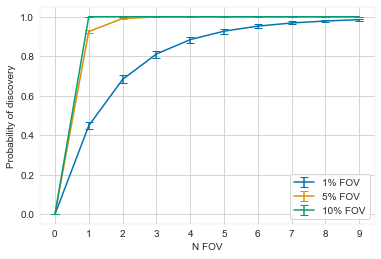

In [127]:
from scipy import stats
import matplotlib
from matplotlib import cm, colors
import matplotlib.pyplot as plt

ns = np.arange(0,10)
matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial'})

labels = ['0.5% FOV, osmFISH', '1% FOV', '5% FOV', '10% FOV',
          '0.5% FOV, IST', '1% FOV, IST', '5% FOV, IST', '10% FOV, IST']
arrs = [fov_05r, fov_1r, fov_5r, fov_10r]
sns.set_style('whitegrid')
sns.set_palette('colorblind')
for i in range(1, len(arrs)):
    mean, ci = calc_errs(arrs[i], ci=0.95)
    plt.errorbar(ns, mean, yerr=ci, label=str(labels[i]), capsize=4)

    _ = plt.xticks(ticks=ns)
    plt.xlabel(r'N FOV')
    plt.ylabel(r'Probability of discovery')
    plt.legend()
    #plt.tight_layout()
    #plt.savefig('../fig/nFOVs_cell'+str(toi)+'discovery_ci95.pdf')

plt.savefig('./spleen_data/figures/FigureS3B.pdf')

In [103]:
ns

array([110,  90,  98, 100, 112,  96, 102, 103,  96, 108, 115,  98,  98,
       112, 107,  92,  98, 114, 122, 110])

'ks = np.linspace(1e-9, 5)\nplt.plot(ks, f2(ks, p0, m))'

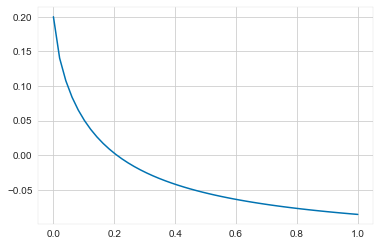

In [121]:
def f2(k, p0, m):
            return np.power((m/k + 1), -k) - p0
    
n_toi_observed,ns = fov_cell_counts(df, fov_size_05r, toi, n_fov, x_min, x_max, y_min, y_max, n_cell_types, ret_n=True)
values, counts = np.unique(n_toi_observed, return_counts=True)
v = np.arange(0, max(values) + 1)
val_count = dict(zip(values, counts))
c = np.array([val_count[i] if i in values else 0 for i in v])
'''plt.bar(v, c, color='g')
_ = plt.xticks(ticks=v)'''

n0 = c[0]
N = np.sum(c)
p0 = n0/N
m = np.mean(n_toi_observed)

ks = np.linspace(1e-9, 1)
plt.plot(ks, f2(ks, p0, m))

'''ks = np.linspace(1e-9, 5)
plt.plot(ks, f2(ks, p0, m))'''